In [53]:
# Core libraries
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false" # Get rid of warnings

# Transformers and PEFT
from transformers import AutoTokenizer, AutoModel, BertConfig
from peft import LoraConfig, get_peft_model

# Data processing and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

# Utilities
import gc
from tqdm.auto import tqdm 

# Set style for prettier plots
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100

print("✓ All libraries imported successfully!")

✓ All libraries imported successfully!


In [54]:
config = BertConfig.from_pretrained("zhihan1996/DNABERT-2-117M")
tokenizer = AutoTokenizer.from_pretrained("zhihan1996/DNABERT-2-117M", trust_remote_code=True)
model = AutoModel.from_config(config)

In [56]:
# Read in the new sequence data and run head to see the overall data structure
data_in = pd.read_csv("data/sequence-cleaner.tsv", sep='\t') 
data_in.head

<bound method NDFrame.head of                genus        species  \
0      Kitasatospora        hibisci   
1     Peterkaempfera      podocarpi   
2       Streptomyces       citrinus   
3            Dickeya       ananatis   
4     Microbacterium       wangruii   
...              ...            ...   
6774     Selenomonas    ruminantium   
6775      Nonomuraea  roseoviolacea   
6776        Listeria       ivanovii   
6777    Streptomyces          albus   
6778   Mycobacterium          avium   

                                               sequence   identifier  \
0     TTCACGGAGAGTTTGATCCTGGCTCAGGACGAACGCTGGCGGCGTG...  NR_200017.1   
1     TTCACGGAGAGTTTGATCCTGGCTCAGGACGAACGCTGGCGGCGTG...  NR_200001.1   
2     AGAGTTTGATCCTGGCTCAGGACGAACGCTGGCGGCGTGCTTAACA...  NR_199987.1   
3     AAATTGAAGAGTTTGATCATGGCTCAGATTGAACGCTGGCGGCAGG...  NR_199979.1   
4     AGAGTTTGATCATGGCTCAGGATGAACGCTGGCGGCGTGCTTAACA...  NR_199966.1   
...                                                 ...          ... 

In [57]:
# Check the columns
print("Column 1:")
print(data_in.iloc[:, 0])
print("Column 2:")
print(data_in.iloc[:, 1])
print("Column 3:")
print(data_in.iloc[:, 2])

Column 1:
0        Kitasatospora
1       Peterkaempfera
2         Streptomyces
3              Dickeya
4       Microbacterium
             ...      
6774       Selenomonas
6775        Nonomuraea
6776          Listeria
6777      Streptomyces
6778     Mycobacterium
Name: genus, Length: 6779, dtype: object
Column 2:
0             hibisci
1           podocarpi
2            citrinus
3            ananatis
4            wangruii
            ...      
6774      ruminantium
6775    roseoviolacea
6776         ivanovii
6777            albus
6778            avium
Name: species, Length: 6779, dtype: object
Column 3:
0       TTCACGGAGAGTTTGATCCTGGCTCAGGACGAACGCTGGCGGCGTG...
1       TTCACGGAGAGTTTGATCCTGGCTCAGGACGAACGCTGGCGGCGTG...
2       AGAGTTTGATCCTGGCTCAGGACGAACGCTGGCGGCGTGCTTAACA...
3       AAATTGAAGAGTTTGATCATGGCTCAGATTGAACGCTGGCGGCAGG...
4       AGAGTTTGATCATGGCTCAGGATGAACGCTGGCGGCGTGCTTAACA...
                              ...                        
6774    ATGCAAGTCGAACGAGGTAATTGAAAGCTTGCTTT

In [58]:
data_in.sequence

0       TTCACGGAGAGTTTGATCCTGGCTCAGGACGAACGCTGGCGGCGTG...
1       TTCACGGAGAGTTTGATCCTGGCTCAGGACGAACGCTGGCGGCGTG...
2       AGAGTTTGATCCTGGCTCAGGACGAACGCTGGCGGCGTGCTTAACA...
3       AAATTGAAGAGTTTGATCATGGCTCAGATTGAACGCTGGCGGCAGG...
4       AGAGTTTGATCATGGCTCAGGATGAACGCTGGCGGCGTGCTTAACA...
                              ...                        
6774    ATGCAAGTCGAACGAGGTAATTGAAAGCTTGCTTTTGAGAACCGAG...
6775    TCGAGCGGCGAACGGGTGAGTAACACGTGAGCAACCTGCCCCTGAC...
6776    AATACATGCAAGTCGAACGAACGGAGGAAGAGCTTGCTCTTCCAAA...
6777    AACGCTGGCGGCGTGCTTAACACATGCAAGTCGAACGATGAACCCG...
6778    GACGAACGCTGGCGGCGTGCTTAACACATGCAAGTCGAACGGAAAG...
Name: sequence, Length: 6779, dtype: object

In [59]:
# Convert the new sequences to input tokens, view the first element
inputs = tokenizer(data_in.sequence.to_list())["input_ids"]
print(inputs[0])

[1, 115, 174, 222, 23, 177, 143, 33, 166, 403, 247, 123, 150, 527, 2759, 2834, 52, 919, 72, 103, 254, 30, 841, 72, 61, 68, 1695, 328, 54, 205, 3358, 1016, 519, 45, 72, 1200, 137, 1339, 252, 64, 209, 266, 788, 103, 45, 241, 745, 111, 914, 36, 118, 2139, 1587, 316, 97, 679, 628, 76, 1138, 3924, 1834, 136, 2063, 2553, 229, 201, 2369, 100, 72, 755, 78, 1527, 71, 148, 30, 200, 43, 763, 97, 409, 876, 111, 405, 169, 1419, 117, 2275, 64, 72, 31, 120, 559, 607, 200, 25, 1818, 61, 72, 1392, 151, 706, 443, 79, 37, 123, 619, 36, 247, 137, 194, 351, 93, 764, 90, 57, 110, 354, 120, 212, 16, 522, 72, 74, 685, 41, 33, 964, 1220, 15, 150, 102, 15, 220, 51, 93, 1527, 253, 37, 2548, 522, 329, 16, 482, 3434, 315, 103, 265, 159, 113, 591, 57, 140, 103, 19, 259, 174, 304, 229, 3810, 118, 622, 1538, 577, 117, 841, 203, 24, 113, 205, 35, 553, 169, 120, 134, 200, 681, 48, 1138, 3154, 270, 41, 103, 1078, 233, 159, 84, 31, 102, 1149, 282, 1435, 3274, 280, 386, 482, 846, 599, 159, 801, 708, 1788, 540, 10, 93, 547

In [60]:
# Set all random seeds for reproducibility
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
np.random.seed(42)

print("✓ Random seeds set for reproducibility")

✓ Random seeds set for reproducibility


In [61]:
# Helper function to count trainable parameters
def print_trainable_parameters(model):
    """Count and display trainable vs total parameters."""
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    
    trainable_pct = 100 * trainable_params / all_param
    print(f"  Trainable params: {trainable_params:,}")
    print(f"  Total params: {all_param:,}")
    print(f"  Trainable: {trainable_pct:.2f}%")

# Configure LoRA
lora_config = LoraConfig(
    r=8,                              # Rank (lower = fewer params)
    lora_alpha=32,                    # Scaling factor
    target_modules=["query", "value"], # Adapt attention layers
    lora_dropout=0.1,                 # Regularization
    bias="none",                      # Don't adapt bias terms
)

# Apply LoRA to the model
print("🔄 Applying LoRA adapters to model...\n")
ft_model = get_peft_model(model, lora_config)

print("📊 Model Parameters Comparison:")
print("-" * 60)
print("Before LoRA (original model):")
print_trainable_parameters(model)
print("\nAfter LoRA (adapted model):")
print_trainable_parameters(ft_model)
print("-" * 60)
print("\n✓ LoRA adapters applied successfully!")

🔄 Applying LoRA adapters to model...

📊 Model Parameters Comparison:
------------------------------------------------------------
Before LoRA (original model):
  Trainable params: 294,912
  Total params: 89,481,984
  Trainable: 0.33%

After LoRA (adapted model):
  Trainable params: 294,912
  Total params: 89,481,984
  Trainable: 0.33%
------------------------------------------------------------

✓ LoRA adapters applied successfully!


In [62]:
# Create the train-val-test splits
# Configuration
prop_train = 0.8
prop_val = 0.1
prop_test = 0.1
SEED = 42

# Create random splits
rng = np.random.default_rng(SEED)
random_idxs = rng.permutation(len(data_in))

# Calculate split sizes
n_total = len(data_in)
n_train = int(prop_train * n_total)
n_val = int(prop_val * n_total)

train_df = data_in.iloc[random_idxs[:n_train]]
val_df = data_in.iloc[random_idxs[n_train:n_train + n_val]]
test_df = data_in.iloc[random_idxs[n_train + n_val:]]

In [63]:
# Custom PyTorch Dataset for protein sequences
class SequenceDataset(Dataset):
    """
    Dataset class that tokenizes protein sequences on-the-fly.
    """
    def __init__(self, df, tokenizer, max_length=512):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        sequence = row["sequence"]
        label = torch.tensor(row["genus"], dtype=torch.float32)

        # Tokenize sequence
        inputs = self.tokenizer(
            sequence,
            padding="max_length",
            max_length=self.max_length,
            truncation=True,
        )
        # Remove batch dimension
        inputs = {k: v.squeeze(0) for k, v in inputs.items()}
        return inputs, label

print("✓ SequenceDataset class defined")

✓ SequenceDataset class defined


In [64]:
# Create dataset instances
train_dataset = SequenceDataset(train_df, tokenizer)
val_dataset = SequenceDataset(val_df, tokenizer)
test_dataset = SequenceDataset(test_df, tokenizer)

print("✓ Datasets created:")
print(f"  Train: {len(train_dataset):,} samples")
print(f"  Val: {len(val_dataset):,} samples")
print(f"  Test: {len(test_dataset):,} samples")

✓ Datasets created:
  Train: 5,423 samples
  Val: 677 samples
  Test: 679 samples


In [65]:
# Training configuration
BATCH_SIZE = 128  
LEARNING_RATE = 2e-4
NUM_WORKERS = 8
NUM_EPOCHS = 40

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# =============================================================================
# Step 1: Create Label Encodings for Species
# =============================================================================

# Encode species names as integers
label_encoder = LabelEncoder()
label_encoder.fit(data_in['genus'])

# Add encoded labels to dataframes
train_df = train_df.copy()
val_df = val_df.copy()
test_df = test_df.copy()

train_df['genus_encoded'] = label_encoder.transform(train_df['genus'])
val_df['genus_encoded'] = label_encoder.transform(val_df['genus'])
test_df['genus_encoded'] = label_encoder.transform(test_df['genus'])

num_classes = len(label_encoder.classes_)
print(f"\n✓ Label encoding complete:")
print(f"  Number of unique species: {num_classes}")
print(f"  Example: '{label_encoder.classes_[0]}' -> {0}")

# =============================================================================
# Step 2: Update Dataset Class for Classification
# =============================================================================
class SequenceClassificationDataset(Dataset):
    """
    Dataset class for species classification with integer labels.
    """
    def __init__(self, df, tokenizer, max_length=512):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        sequence = row["sequence"]
        label = torch.tensor(row["genus_encoded"], dtype=torch.long)  # Long for classification

        # Tokenize sequence
        inputs = self.tokenizer(
            sequence,
            padding="max_length",
            max_length=self.max_length,
            truncation=True,
            return_tensors="pt"
        )
        # Remove batch dimension
        inputs = {k: v.squeeze(0) for k, v in inputs.items()}
        return inputs, label

Using device: cuda

✓ Label encoding complete:
  Number of unique species: 222
  Example: 'Acetobacter' -> 0


In [66]:
# Create Classification Model with LoRA
class DNABERTClassifier(nn.Module):
    """
    Combines LoRA-adapted DNABERT with classification head.
    """
    def __init__(self, base_model, num_classes, hidden_size=768):
        super().__init__()
        self.base_model = base_model  # LoRA-wrapped DNABERT
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(hidden_size, num_classes)
        
    def forward(self, input_ids, attention_mask=None, **kwargs):
        # Get embeddings from DNABERT
        outputs = self.base_model(
            input_ids=input_ids, 
            attention_mask=attention_mask
        )
        
        # Use [CLS] token representation (first token)
        cls_output = outputs.last_hidden_state[:, 0, :]
        
        # Apply dropout and classification head
        cls_output = self.dropout(cls_output)
        logits = self.classifier(cls_output)
        
        return logits

In [67]:
# Instantiate Model
classification_model = DNABERTClassifier(
    base_model=ft_model,  # LoRA-adapted model
    num_classes=num_classes,
    hidden_size=768  # DNABERT-2-117M hidden size
).to(device)

print("\n🎯 Complete Model Architecture:")
print("-" * 60)
print_trainable_parameters(classification_model)
print("-" * 60)

# Create DataLoaders
train_dataset = SequenceClassificationDataset(train_df, tokenizer)
val_dataset = SequenceClassificationDataset(val_df, tokenizer)
test_dataset = SequenceClassificationDataset(test_df, tokenizer)

train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=NUM_WORKERS
)
val_loader = DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=NUM_WORKERS
)
test_loader = DataLoader(
    test_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=NUM_WORKERS
)

print(f"\n✓ DataLoaders created:")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches: {len(val_loader)}")
print(f"  Test batches: {len(test_loader)}")


🎯 Complete Model Architecture:
------------------------------------------------------------
  Trainable params: 465,630
  Total params: 89,652,702
  Trainable: 0.52%
------------------------------------------------------------

✓ DataLoaders created:
  Train batches: 43
  Val batches: 6
  Test batches: 6


In [68]:
# Setup Training Components
# Optimizer - only update trainable parameters
optimizer = AdamW(
    filter(lambda p: p.requires_grad, classification_model.parameters()), 
    lr=LEARNING_RATE,
    weight_decay=0.01
)

# Loss function for multi-class classification
loss_fn = nn.CrossEntropyLoss()

# Learning rate scheduler
from torch.optim.lr_scheduler import CosineAnnealingLR
scheduler = CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)

print("\n✓ Training setup complete!")
print(f"  Optimizer: AdamW (lr={LEARNING_RATE})")
print(f"  Loss: CrossEntropyLoss")
print(f"  Scheduler: CosineAnnealingLR")


✓ Training setup complete!
  Optimizer: AdamW (lr=0.0002)
  Loss: CrossEntropyLoss
  Scheduler: CosineAnnealingLR


In [77]:
# Training Loop
def train_epoch(model, loader, optimizer, loss_fn, device):
    """Train for one epoch."""
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    progress_bar = tqdm(loader, desc="Training")
    for inputs, labels in progress_bar:
        # Move to device
        inputs = {k: v.to(device) for k, v in inputs.items()}
        labels = labels.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        logits = model(**inputs)
        loss = loss_fn(logits, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Track metrics
        total_loss += loss.item()
        predictions = logits.argmax(dim=1)
        correct += (predictions == labels).sum().item()
        total += labels.size(0)
        
        # Update progress bar
        progress_bar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100 * correct / total:.2f}%'
        })
    
    return total_loss / len(loader), correct / total

def evaluate(model, loader, loss_fn, device):
    """Evaluate model on validation/test set."""
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc="Evaluating"):
            inputs = {k: v.to(device) for k, v in inputs.items()}
            labels = labels.to(device)
            
            logits = model(**inputs)
            loss = loss_fn(logits, labels)
            
            total_loss += loss.item()
            predictions = logits.argmax(dim=1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)
    
    return total_loss / len(loader), correct / total


In [79]:
import numpy as np
from sklearn.metrics import balanced_accuracy_score, f1_score

# Training Loop
def train_epoch(model, loader, optimizer, loss_fn, device):
    """Train for one epoch."""
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    y_true_all, y_pred_all = [], []
    
    progress_bar = tqdm(loader, desc="Training")
    for inputs, labels in progress_bar:
        # Move to device
        inputs = {k: v.to(device) for k, v in inputs.items()}
        labels = labels.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        logits = model(**inputs)
        loss = loss_fn(logits, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Track metrics (batch)
        total_loss += loss.item()
        predictions = logits.argmax(dim=1)

        correct += (predictions == labels).sum().item()
        total += labels.size(0)

        # Accumulate for epoch-level metrics
        y_true_all.append(labels.detach().cpu().numpy())
        y_pred_all.append(predictions.detach().cpu().numpy())
        
        # Update progress bar
        progress_bar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100 * correct / total:.2f}%'
        })
    
    # Epoch-level metrics
    y_true_all = np.concatenate(y_true_all)
    y_pred_all = np.concatenate(y_pred_all)
    epoch_acc = correct / total
    epoch_bal_acc = balanced_accuracy_score(y_true_all, y_pred_all)
    epoch_f1_macro = f1_score(y_true_all, y_pred_all, average='macro', zero_division=0)
    
    return total_loss / len(loader), epoch_acc, epoch_bal_acc, epoch_f1_macro

def evaluate(model, loader, loss_fn, device):
    """Evaluate model on validation/test set."""
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    y_true_all, y_pred_all = [], []
    
    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc="Evaluating"):
            inputs = {k: v.to(device) for k, v in inputs.items()}
            labels = labels.to(device)
            
            logits = model(**inputs)
            loss = loss_fn(logits, labels)
            
            total_loss += loss.item()
            predictions = logits.argmax(dim=1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

            y_true_all.append(labels.detach().cpu().numpy())
            y_pred_all.append(predictions.detach().cpu().numpy())
    
    y_true_all = np.concatenate(y_true_all)
    y_pred_all = np.concatenate(y_pred_all)
    epoch_acc = correct / total
    epoch_bal_acc = balanced_accuracy_score(y_true_all, y_pred_all)
    epoch_f1_macro = f1_score(y_true_all, y_pred_all, average='macro', zero_division=0)
    
    return total_loss / len(loader), epoch_acc, epoch_bal_acc, epoch_f1_macro

# Train the model and record training history
history = {
    'train_loss': [],
    'train_acc': [],
    'train_bal_acc': [],
    'train_f1_macro': [],
    'val_loss': [],
    'val_acc': [],
    'val_bal_acc': [],
    'val_f1_macro': []
}

print("\n" + "=" * 60)
print("🚀 Starting Training!")
print("=" * 60)
best_val_acc = 0.0
for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch + 1}/{NUM_EPOCHS}")
    print("-" * 60)
    
    # Train
    train_loss, train_acc, train_bal_acc, train_f1 = train_epoch(
        classification_model, train_loader, optimizer, loss_fn, device
    )
    
    # Validate
    val_loss, val_acc, val_bal_acc, val_f1 = evaluate(
        classification_model, val_loader, loss_fn, device
    )
    
    # Update scheduler
    scheduler.step()
    
    # Store metrics
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['train_bal_acc'].append(train_bal_acc)
    history['train_f1_macro'].append(train_f1)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_bal_acc'].append(val_bal_acc)
    history['val_f1_macro'].append(val_f1)
    
    # Print epoch summary
    print(f"\n📊 Epoch {epoch + 1} Summary:")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc * 100:.2f}%"
          f" | Train BalAcc: {train_bal_acc * 100:.2f}% | Train F1(macro): {train_f1:.3f}")
    print(f"  Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc * 100:.2f}%"
          f" | Val   BalAcc: {val_bal_acc * 100:.2f}% | Val   F1(macro): {val_f1:.3f}")
    
    # Save best model (still based on val_acc; change to val_bal_acc or val_f1 if preferred)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(classification_model.state_dict(), 'best_model_cleanerfile.pt')
        print(f"  ✓ New best model saved! (Val Acc: {val_acc * 100:.2f}%)")

print("\n" + "=" * 60)
print("✓ Training Complete!")
print("=" * 60)
print(f"Best Validation Accuracy: {best_val_acc * 100:.2f}%")


🚀 Starting Training!

Epoch 1/40
------------------------------------------------------------


Evaluating: 100%|██████████| 6/6 [00:02<00:00,  2.35it/s]
/opt/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")



📊 Epoch 1 Summary:
  Train Loss: 2.9830 | Train Acc: 37.36% | Train BalAcc: 8.35% | Train F1(macro): 0.066
  Val   Loss: 2.7183 | Val   Acc: 40.92% | Val   BalAcc: 13.83% | Val   F1(macro): 0.099
  ✓ New best model saved! (Val Acc: 40.92%)

Epoch 2/40
------------------------------------------------------------


Evaluating: 100%|██████████| 6/6 [00:02<00:00,  2.29it/s]
/opt/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")



📊 Epoch 2 Summary:
  Train Loss: 2.5388 | Train Acc: 44.70% | Train BalAcc: 12.99% | Train F1(macro): 0.110
  Val   Loss: 2.3393 | Val   Acc: 44.02% | Val   BalAcc: 18.34% | Val   F1(macro): 0.139
  ✓ New best model saved! (Val Acc: 44.02%)

Epoch 3/40
------------------------------------------------------------


Evaluating: 100%|██████████| 6/6 [00:02<00:00,  2.29it/s]
/opt/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")



📊 Epoch 3 Summary:
  Train Loss: 2.1424 | Train Acc: 51.78% | Train BalAcc: 19.66% | Train F1(macro): 0.178
  Val   Loss: 2.0314 | Val   Acc: 49.19% | Val   BalAcc: 22.82% | Val   F1(macro): 0.179
  ✓ New best model saved! (Val Acc: 49.19%)

Epoch 4/40
------------------------------------------------------------


Evaluating: 100%|██████████| 6/6 [00:02<00:00,  2.32it/s]
/opt/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")



📊 Epoch 4 Summary:
  Train Loss: 1.8105 | Train Acc: 58.82% | Train BalAcc: 27.37% | Train F1(macro): 0.263
  Val   Loss: 1.6760 | Val   Acc: 57.46% | Val   BalAcc: 31.95% | Val   F1(macro): 0.263
  ✓ New best model saved! (Val Acc: 57.46%)

Epoch 5/40
------------------------------------------------------------


Evaluating: 100%|██████████| 6/6 [00:02<00:00,  2.22it/s]
/opt/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")



📊 Epoch 5 Summary:
  Train Loss: 1.5333 | Train Acc: 65.26% | Train BalAcc: 36.10% | Train F1(macro): 0.360
  Val   Loss: 1.4364 | Val   Acc: 63.96% | Val   BalAcc: 39.46% | Val   F1(macro): 0.335
  ✓ New best model saved! (Val Acc: 63.96%)

Epoch 6/40
------------------------------------------------------------


Evaluating: 100%|██████████| 6/6 [00:02<00:00,  2.27it/s]
/opt/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")



📊 Epoch 6 Summary:
  Train Loss: 1.3044 | Train Acc: 71.23% | Train BalAcc: 45.24% | Train F1(macro): 0.457
  Val   Loss: 1.2357 | Val   Acc: 69.57% | Val   BalAcc: 46.83% | Val   F1(macro): 0.413
  ✓ New best model saved! (Val Acc: 69.57%)

Epoch 7/40
------------------------------------------------------------


Evaluating: 100%|██████████| 6/6 [00:02<00:00,  2.35it/s]
/opt/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")



📊 Epoch 7 Summary:
  Train Loss: 1.1347 | Train Acc: 75.09% | Train BalAcc: 51.71% | Train F1(macro): 0.529
  Val   Loss: 1.0723 | Val   Acc: 74.15% | Val   BalAcc: 54.35% | Val   F1(macro): 0.491
  ✓ New best model saved! (Val Acc: 74.15%)

Epoch 8/40
------------------------------------------------------------


Evaluating: 100%|██████████| 6/6 [00:02<00:00,  2.31it/s]
/opt/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")



📊 Epoch 8 Summary:
  Train Loss: 0.9662 | Train Acc: 79.77% | Train BalAcc: 60.72% | Train F1(macro): 0.625
  Val   Loss: 0.9464 | Val   Acc: 79.03% | Val   BalAcc: 62.63% | Val   F1(macro): 0.576
  ✓ New best model saved! (Val Acc: 79.03%)

Epoch 9/40
------------------------------------------------------------


Evaluating: 100%|██████████| 6/6 [00:02<00:00,  2.31it/s]
/opt/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")



📊 Epoch 9 Summary:
  Train Loss: 0.8615 | Train Acc: 81.86% | Train BalAcc: 65.58% | Train F1(macro): 0.672
  Val   Loss: 0.8671 | Val   Acc: 79.91% | Val   BalAcc: 65.72% | Val   F1(macro): 0.609
  ✓ New best model saved! (Val Acc: 79.91%)

Epoch 10/40
------------------------------------------------------------


Evaluating: 100%|██████████| 6/6 [00:02<00:00,  2.29it/s]
/opt/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")



📊 Epoch 10 Summary:
  Train Loss: 0.7714 | Train Acc: 84.38% | Train BalAcc: 69.96% | Train F1(macro): 0.719
  Val   Loss: 0.7830 | Val   Acc: 81.54% | Val   BalAcc: 69.32% | Val   F1(macro): 0.631
  ✓ New best model saved! (Val Acc: 81.54%)

Epoch 11/40
------------------------------------------------------------


Evaluating: 100%|██████████| 6/6 [00:02<00:00,  2.32it/s]
/opt/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")



📊 Epoch 11 Summary:
  Train Loss: 0.6975 | Train Acc: 86.45% | Train BalAcc: 74.44% | Train F1(macro): 0.767
  Val   Loss: 0.7274 | Val   Acc: 82.42% | Val   BalAcc: 70.24% | Val   F1(macro): 0.649
  ✓ New best model saved! (Val Acc: 82.42%)

Epoch 12/40
------------------------------------------------------------


Evaluating: 100%|██████████| 6/6 [00:02<00:00,  2.34it/s]
/opt/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")



📊 Epoch 12 Summary:
  Train Loss: 0.6375 | Train Acc: 87.42% | Train BalAcc: 76.33% | Train F1(macro): 0.782
  Val   Loss: 0.6723 | Val   Acc: 83.31% | Val   BalAcc: 70.68% | Val   F1(macro): 0.655
  ✓ New best model saved! (Val Acc: 83.31%)

Epoch 13/40
------------------------------------------------------------


Evaluating: 100%|██████████| 6/6 [00:02<00:00,  2.27it/s]
/opt/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")



📊 Epoch 13 Summary:
  Train Loss: 0.5882 | Train Acc: 88.71% | Train BalAcc: 78.92% | Train F1(macro): 0.806
  Val   Loss: 0.6329 | Val   Acc: 84.93% | Val   BalAcc: 74.81% | Val   F1(macro): 0.696
  ✓ New best model saved! (Val Acc: 84.93%)

Epoch 14/40
------------------------------------------------------------


Evaluating: 100%|██████████| 6/6 [00:02<00:00,  2.25it/s]
/opt/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")



📊 Epoch 14 Summary:
  Train Loss: 0.5426 | Train Acc: 90.25% | Train BalAcc: 81.77% | Train F1(macro): 0.837
  Val   Loss: 0.5830 | Val   Acc: 86.12% | Val   BalAcc: 75.64% | Val   F1(macro): 0.702
  ✓ New best model saved! (Val Acc: 86.12%)

Epoch 15/40
------------------------------------------------------------


Evaluating: 100%|██████████| 6/6 [00:02<00:00,  2.37it/s]
/opt/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")



📊 Epoch 15 Summary:
  Train Loss: 0.4978 | Train Acc: 91.08% | Train BalAcc: 83.26% | Train F1(macro): 0.850
  Val   Loss: 0.5631 | Val   Acc: 85.97% | Val   BalAcc: 76.48% | Val   F1(macro): 0.716

Epoch 16/40
------------------------------------------------------------


Evaluating: 100%|██████████| 6/6 [00:02<00:00,  2.30it/s]
/opt/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")



📊 Epoch 16 Summary:
  Train Loss: 0.4746 | Train Acc: 90.82% | Train BalAcc: 83.37% | Train F1(macro): 0.850
  Val   Loss: 0.5324 | Val   Acc: 86.41% | Val   BalAcc: 76.53% | Val   F1(macro): 0.712
  ✓ New best model saved! (Val Acc: 86.41%)

Epoch 17/40
------------------------------------------------------------


Evaluating: 100%|██████████| 6/6 [00:02<00:00,  2.30it/s]
/opt/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")



📊 Epoch 17 Summary:
  Train Loss: 0.4479 | Train Acc: 92.38% | Train BalAcc: 85.64% | Train F1(macro): 0.873
  Val   Loss: 0.5205 | Val   Acc: 87.00% | Val   BalAcc: 77.02% | Val   F1(macro): 0.724
  ✓ New best model saved! (Val Acc: 87.00%)

Epoch 18/40
------------------------------------------------------------


Evaluating: 100%|██████████| 6/6 [00:02<00:00,  2.32it/s]
/opt/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")



📊 Epoch 18 Summary:
  Train Loss: 0.4193 | Train Acc: 92.53% | Train BalAcc: 86.05% | Train F1(macro): 0.879
  Val   Loss: 0.5031 | Val   Acc: 87.15% | Val   BalAcc: 77.80% | Val   F1(macro): 0.721
  ✓ New best model saved! (Val Acc: 87.15%)

Epoch 19/40
------------------------------------------------------------


Evaluating: 100%|██████████| 6/6 [00:02<00:00,  2.38it/s]
/opt/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")



📊 Epoch 19 Summary:
  Train Loss: 0.3985 | Train Acc: 93.21% | Train BalAcc: 87.90% | Train F1(macro): 0.891
  Val   Loss: 0.4854 | Val   Acc: 87.44% | Val   BalAcc: 78.63% | Val   F1(macro): 0.732
  ✓ New best model saved! (Val Acc: 87.44%)

Epoch 20/40
------------------------------------------------------------


Evaluating: 100%|██████████| 6/6 [00:02<00:00,  2.30it/s]
/opt/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")



📊 Epoch 20 Summary:
  Train Loss: 0.3852 | Train Acc: 93.69% | Train BalAcc: 88.36% | Train F1(macro): 0.897
  Val   Loss: 0.4744 | Val   Acc: 87.44% | Val   BalAcc: 78.77% | Val   F1(macro): 0.735

Epoch 21/40
------------------------------------------------------------


Evaluating: 100%|██████████| 6/6 [00:02<00:00,  2.25it/s]
/opt/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")



📊 Epoch 21 Summary:
  Train Loss: 0.3743 | Train Acc: 93.73% | Train BalAcc: 88.62% | Train F1(macro): 0.903
  Val   Loss: 0.4577 | Val   Acc: 88.18% | Val   BalAcc: 79.49% | Val   F1(macro): 0.742
  ✓ New best model saved! (Val Acc: 88.18%)

Epoch 22/40
------------------------------------------------------------


Evaluating: 100%|██████████| 6/6 [00:02<00:00,  2.31it/s]
/opt/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")



📊 Epoch 22 Summary:
  Train Loss: 0.3601 | Train Acc: 94.03% | Train BalAcc: 89.24% | Train F1(macro): 0.904
  Val   Loss: 0.4495 | Val   Acc: 87.89% | Val   BalAcc: 79.30% | Val   F1(macro): 0.742

Epoch 23/40
------------------------------------------------------------


Evaluating: 100%|██████████| 6/6 [00:02<00:00,  2.27it/s]
/opt/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")



📊 Epoch 23 Summary:
  Train Loss: 0.3460 | Train Acc: 94.27% | Train BalAcc: 89.66% | Train F1(macro): 0.908
  Val   Loss: 0.4495 | Val   Acc: 88.04% | Val   BalAcc: 80.13% | Val   F1(macro): 0.749

Epoch 24/40
------------------------------------------------------------


Evaluating: 100%|██████████| 6/6 [00:02<00:00,  2.30it/s]
/opt/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")



📊 Epoch 24 Summary:
  Train Loss: 0.3383 | Train Acc: 94.84% | Train BalAcc: 90.31% | Train F1(macro): 0.916
  Val   Loss: 0.4409 | Val   Acc: 87.89% | Val   BalAcc: 79.32% | Val   F1(macro): 0.739

Epoch 25/40
------------------------------------------------------------


Evaluating: 100%|██████████| 6/6 [00:02<00:00,  2.21it/s]
/opt/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")



📊 Epoch 25 Summary:
  Train Loss: 0.3296 | Train Acc: 94.32% | Train BalAcc: 89.90% | Train F1(macro): 0.910
  Val   Loss: 0.4320 | Val   Acc: 88.77% | Val   BalAcc: 80.94% | Val   F1(macro): 0.756
  ✓ New best model saved! (Val Acc: 88.77%)

Epoch 26/40
------------------------------------------------------------


Evaluating: 100%|██████████| 6/6 [00:02<00:00,  2.26it/s]
/opt/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")



📊 Epoch 26 Summary:
  Train Loss: 0.3261 | Train Acc: 94.97% | Train BalAcc: 90.79% | Train F1(macro): 0.920
  Val   Loss: 0.4295 | Val   Acc: 88.48% | Val   BalAcc: 80.71% | Val   F1(macro): 0.754

Epoch 27/40
------------------------------------------------------------


Evaluating: 100%|██████████| 6/6 [00:02<00:00,  2.33it/s]
/opt/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")



📊 Epoch 27 Summary:
  Train Loss: 0.3175 | Train Acc: 95.35% | Train BalAcc: 91.47% | Train F1(macro): 0.927
  Val   Loss: 0.4259 | Val   Acc: 88.77% | Val   BalAcc: 81.01% | Val   F1(macro): 0.752

Epoch 28/40
------------------------------------------------------------


Evaluating: 100%|██████████| 6/6 [00:02<00:00,  2.25it/s]
/opt/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")



📊 Epoch 28 Summary:
  Train Loss: 0.3145 | Train Acc: 94.95% | Train BalAcc: 91.05% | Train F1(macro): 0.921
  Val   Loss: 0.4211 | Val   Acc: 88.92% | Val   BalAcc: 81.29% | Val   F1(macro): 0.756
  ✓ New best model saved! (Val Acc: 88.92%)

Epoch 29/40
------------------------------------------------------------


Evaluating: 100%|██████████| 6/6 [00:02<00:00,  2.28it/s]
/opt/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")



📊 Epoch 29 Summary:
  Train Loss: 0.3134 | Train Acc: 94.87% | Train BalAcc: 90.95% | Train F1(macro): 0.920
  Val   Loss: 0.4180 | Val   Acc: 88.77% | Val   BalAcc: 81.10% | Val   F1(macro): 0.758

Epoch 30/40
------------------------------------------------------------


Evaluating: 100%|██████████| 6/6 [00:02<00:00,  2.31it/s]
/opt/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")



📊 Epoch 30 Summary:
  Train Loss: 0.3116 | Train Acc: 95.24% | Train BalAcc: 91.62% | Train F1(macro): 0.925
  Val   Loss: 0.4155 | Val   Acc: 89.07% | Val   BalAcc: 81.84% | Val   F1(macro): 0.766
  ✓ New best model saved! (Val Acc: 89.07%)

Epoch 31/40
------------------------------------------------------------


Evaluating: 100%|██████████| 6/6 [00:02<00:00,  2.31it/s]
/opt/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")



📊 Epoch 31 Summary:
  Train Loss: 0.3060 | Train Acc: 95.13% | Train BalAcc: 91.50% | Train F1(macro): 0.926
  Val   Loss: 0.4158 | Val   Acc: 89.07% | Val   BalAcc: 81.84% | Val   F1(macro): 0.767

Epoch 32/40
------------------------------------------------------------


Evaluating: 100%|██████████| 6/6 [00:02<00:00,  2.35it/s]
/opt/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")



📊 Epoch 32 Summary:
  Train Loss: 0.3075 | Train Acc: 95.15% | Train BalAcc: 91.44% | Train F1(macro): 0.924
  Val   Loss: 0.4152 | Val   Acc: 89.07% | Val   BalAcc: 81.84% | Val   F1(macro): 0.767

Epoch 33/40
------------------------------------------------------------


Evaluating: 100%|██████████| 6/6 [00:02<00:00,  2.26it/s]
/opt/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")



📊 Epoch 33 Summary:
  Train Loss: 0.3065 | Train Acc: 95.41% | Train BalAcc: 92.08% | Train F1(macro): 0.929
  Val   Loss: 0.4141 | Val   Acc: 89.07% | Val   BalAcc: 81.84% | Val   F1(macro): 0.767

Epoch 34/40
------------------------------------------------------------


Evaluating: 100%|██████████| 6/6 [00:02<00:00,  2.31it/s]
/opt/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")



📊 Epoch 34 Summary:
  Train Loss: 0.3089 | Train Acc: 95.37% | Train BalAcc: 91.63% | Train F1(macro): 0.927
  Val   Loss: 0.4141 | Val   Acc: 89.07% | Val   BalAcc: 81.84% | Val   F1(macro): 0.767

Epoch 35/40
------------------------------------------------------------


Evaluating: 100%|██████████| 6/6 [00:02<00:00,  2.28it/s]
/opt/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")



📊 Epoch 35 Summary:
  Train Loss: 0.3065 | Train Acc: 95.15% | Train BalAcc: 91.16% | Train F1(macro): 0.921
  Val   Loss: 0.4141 | Val   Acc: 89.07% | Val   BalAcc: 81.84% | Val   F1(macro): 0.767

Epoch 36/40
------------------------------------------------------------


Evaluating: 100%|██████████| 6/6 [00:02<00:00,  2.33it/s]
/opt/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")



📊 Epoch 36 Summary:
  Train Loss: 0.3055 | Train Acc: 95.19% | Train BalAcc: 91.53% | Train F1(macro): 0.926
  Val   Loss: 0.4141 | Val   Acc: 89.07% | Val   BalAcc: 81.84% | Val   F1(macro): 0.767

Epoch 37/40
------------------------------------------------------------


Evaluating: 100%|██████████| 6/6 [00:02<00:00,  2.30it/s]
/opt/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")



📊 Epoch 37 Summary:
  Train Loss: 0.3093 | Train Acc: 95.32% | Train BalAcc: 91.31% | Train F1(macro): 0.924
  Val   Loss: 0.4140 | Val   Acc: 89.07% | Val   BalAcc: 81.84% | Val   F1(macro): 0.767

Epoch 38/40
------------------------------------------------------------


Evaluating: 100%|██████████| 6/6 [00:02<00:00,  2.34it/s]
/opt/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")



📊 Epoch 38 Summary:
  Train Loss: 0.3086 | Train Acc: 95.21% | Train BalAcc: 91.36% | Train F1(macro): 0.925
  Val   Loss: 0.4133 | Val   Acc: 89.07% | Val   BalAcc: 81.84% | Val   F1(macro): 0.767

Epoch 39/40
------------------------------------------------------------


Evaluating: 100%|██████████| 6/6 [00:02<00:00,  2.34it/s]
/opt/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")



📊 Epoch 39 Summary:
  Train Loss: 0.3018 | Train Acc: 95.28% | Train BalAcc: 91.36% | Train F1(macro): 0.924
  Val   Loss: 0.4133 | Val   Acc: 88.92% | Val   BalAcc: 81.29% | Val   F1(macro): 0.760

Epoch 40/40
------------------------------------------------------------


Evaluating: 100%|██████████| 6/6 [00:02<00:00,  2.30it/s]



📊 Epoch 40 Summary:
  Train Loss: 0.3023 | Train Acc: 95.28% | Train BalAcc: 91.60% | Train F1(macro): 0.928
  Val   Loss: 0.4123 | Val   Acc: 88.92% | Val   BalAcc: 81.29% | Val   F1(macro): 0.760

✓ Training Complete!
Best Validation Accuracy: 89.07%


/opt/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


/tmp/ipykernel_110028/4104144755.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  classification_model.load_state_dict(torch.load('best_model_cleanerfile.pt'))



🧪 Evaluating on test set...


Evaluating: 100%|██████████| 6/6 [00:02<00:00,  2.37it/s]
/opt/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")



📈 Final Test Results:
  Test Loss: 0.4018
  Test Accuracy: 90.28%
  Test Balanced Accuracy: 83.12%
  Test F1 Score (Macro): 0.8083


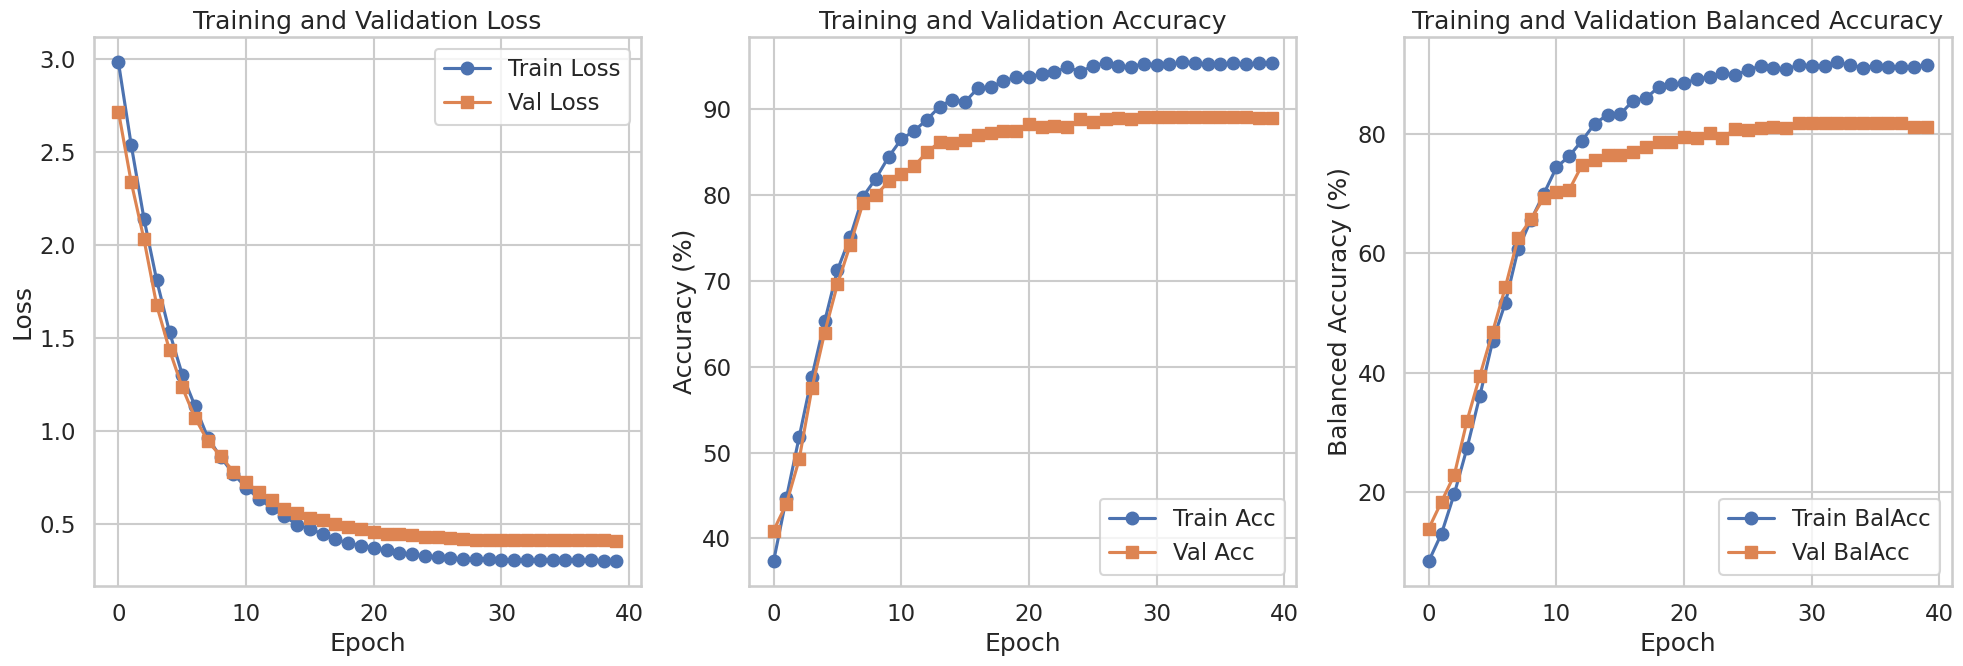


✓ Training history plot saved as 'training_history.png'


In [85]:
# Final Evaluation on Test Set
print("\n🧪 Evaluating on test set...")
classification_model.load_state_dict(torch.load('best_model_cleanerfile.pt'))
test_loss, test_acc, test_bal_acc, test_f1 = evaluate(classification_model, test_loader, loss_fn, device)

print(f"\n📈 Final Test Results:")
print(f"  Test Loss: {test_loss:.4f}")
print(f"  Test Accuracy: {test_acc * 100:.2f}%")
print(f"  Test Balanced Accuracy: {test_bal_acc * 100:.2f}%")
print(f"  Test F1 Score (Macro): {test_f1:.4f}")

# Plot Training History
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 7))

# Loss plot
ax1.plot(history['train_loss'], label='Train Loss', marker='o')
ax1.plot(history['val_loss'], label='Val Loss', marker='s')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True)

# Accuracy plot
ax2.plot([acc * 100 for acc in history['train_acc']], label='Train Acc', marker='o')
ax2.plot([acc * 100 for acc in history['val_acc']], label='Val Acc', marker='s')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True)

# Balanced Accuracy plot
ax3.plot([acc * 100 for acc in history['train_bal_acc']], label='Train BalAcc', marker='o')
ax3.plot([acc * 100 for acc in history['val_bal_acc']], label='Val BalAcc', marker='s')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Balanced Accuracy (%)')
ax3.set_title('Training and Validation Balanced Accuracy')
ax3.legend()
ax3.grid(True)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Training history plot saved as 'training_history.png'")

In [65]:
# Try loading the model
loaded_model = DNABERTClassifier(
    base_model=ft_model,  # LoRA-adapted model
    num_classes=num_classes,
    hidden_size=768  # DNABERT-2-117M hidden size
).to(device)
loaded_model.load_state_dict(torch.load('best_model_cleanerfile.pt', weights_only=False))
loaded_model.to(device)
loaded_model.eval()

DNABERTClassifier(
  (base_model): PeftModel(
    (base_model): LoraModel(
      (model): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(4096, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): BertEncoder(
          (layer): ModuleList(
            (0-11): 12 x BertLayer(
              (attention): BertAttention(
                (self): BertSdpaSelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=768, out_features=768, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.1, inplace=False)
                    )
                    (lora_A): ModuleDict(
                      (default): Linear(in_features=768, out_f

In [68]:
# Test that the model loading worked
with torch.no_grad():
    dummy_input = torch.randint(0, 4096, (1, 100)).to(device)  # batch_size=1, seq_len=100
    output = loaded_model(dummy_input)
    print(f"Output shape: {output.shape}")  # Should be [1, 222]

Output shape: torch.Size([1, 222])


# Layer-wise hidden state analysis

In [74]:
# ============================================================
# GET SAMPLE SEQUENCE AND TOKENIZE
# ============================================================
print("📋 Extracting sample protein sequence...")

# Get a sample protein sequence from the test set
sample_sequence = test_df["sequence"].iloc[0]
print(f"Sample sequence: {sample_sequence[:50]}...")  # Show first 50 characters
print(f"Length: {len(sample_sequence)} nucleotides")

# Tokenize the sequence
print("\n🔤 Tokenizing sequence...")
inputs = tokenizer(sample_sequence, return_tensors="pt", padding=True, truncation=True, add_special_tokens=True)
inputs = {k: v.to(device) for k, v in inputs.items()}

print(f"✓ Input IDs shape: {inputs['input_ids'].shape}")
print(f"  (batch_size=1, sequence_length={inputs['input_ids'].shape[1]})")

📋 Extracting sample protein sequence...
Sample sequence: GACGAACGCTGGCGGCGTGCTTAACACATGCAAGTCGAACGATGAACCTC...
Length: 1480 nucleotides

🔤 Tokenizing sequence...
✓ Input IDs shape: torch.Size([1, 321])
  (batch_size=1, sequence_length=321)


In [71]:
# ============================================================
# EXTRACT HIDDEN STATES FROM ALL LAYERS
# ============================================================
print("🧠 Extracting hidden states from all layers...")

# Access the base BERT model directly
with torch.no_grad():
    # Call the base model, not the classifier wrapper
    outputs = loaded_model.base_model(**inputs, output_hidden_states=True)
    hidden_states = outputs.hidden_states  # Tuple of tensors (num_layers+1, batch_size, seq_len, hidden_dim)
    
print(f"✓ Number of layers: {len(hidden_states)}")
print(f"  Hidden state shape per layer: {hidden_states[0].shape}")
print(f"  (batch_size, sequence_length, hidden_dimension)")

# ============================================================
# EXTRACT CLS TOKEN REPRESENTATIONS ACROSS LAYERS
# ============================================================
print("\n📊 Extracting CLS token representations...")
# Get the CLS token (position 0) representation across all layers
cls_representations = torch.stack([h[:, 0, :] for h in hidden_states])  # (num_layers, batch_size, hidden_dim)
cls_representations = cls_representations.squeeze(1).float().cpu()  # (num_layers, hidden_dim)
# Convert to numpy
cls_representations = cls_representations.numpy()

print(f"✓ CLS representations shape: {cls_representations.shape}")
print(f"  ({len(hidden_states)} layers × {cls_representations.shape[1]} dimensions)")

🧠 Extracting hidden states from all layers...
✓ Number of layers: 13
  Hidden state shape per layer: torch.Size([1, 321, 768])
  (batch_size, sequence_length, hidden_dimension)

📊 Extracting CLS token representations...
✓ CLS representations shape: (13, 768)
  (13 layers × 768 dimensions)


In [72]:
# Use helper functions for the ESM model from tutorial 4
# ============================================================
# EMBEDDING EXTRACTION FUNCTION
# ============================================================
def get_esm_embeddings(seqs, model, tokenizer, device, max_batch=256):
    """
    Extract ESM embeddings for a list of protein sequences.
    
    Parameters:
    -----------
    seqs : list of str
        Protein sequences to embed
    model : AutoModel
        Pre-loaded ESM model
    tokenizer : AutoTokenizer
        Pre-loaded ESM tokenizer
    device : torch.device
        Device to run on (CPU/GPU)
    max_batch : int
        Maximum batch size for processing
        
    Returns:
    --------
    numpy.ndarray
        Array of embeddings, shape (n_sequences, embedding_dim)
    """
    embs = []
    
    with torch.no_grad():
        for i in tqdm(range(0, len(seqs), max_batch), desc="Extracting embeddings"):
            # Get batch of sequences
            batch = seqs[i:i+max_batch]
            
            # Tokenize sequences
            toks = tokenizer(
                batch, 
                return_tensors="pt", 
                padding=True, 
                truncation=True, 
                add_special_tokens=True
            )
            
            # Move to device
            toks = {k: v.to(device) for k, v in toks.items()}
            
            # Extract embeddings
            out = model(**toks, return_dict=True)
            
            # Get CLS token embeddings (first token)
            cls_emb = out.last_hidden_state[:, 0, :]
            
            # Convert to float32, detach, move to CPU
            embs.append(cls_emb.float().detach().cpu())
    
    # Concatenate all batches
    all_embs = torch.cat(embs, dim=0)
    
    # Convert to numpy (using tolist as workaround for potential issues)
    return np.array(all_embs.tolist())


# ============================================================
# HELPER FUNCTION: MAINTAIN ORIGINAL ORDER
# ============================================================
def embed_sequences_in_original_order(seqs, model, tokenizer, device, **kwargs):
    """
    Extract embeddings while maintaining original sequence order.
    Sequences are sorted by length for efficiency, then unsorted.
    
    Parameters:
    -----------
    seqs : list of str
        Protein sequences to embed
    model, tokenizer, device : 
        Model components
    **kwargs : 
        Additional arguments for get_esm_embeddings
        
    Returns:
    --------
    numpy.ndarray
        Embeddings in original sequence order
    """
    # Track original indices
    indexed = list(enumerate(seqs))
    
    # Sort by sequence length for efficiency
    indexed_sorted = sorted(indexed, key=lambda x: len(x[1]))
    sorted_indices, sorted_seqs = zip(*indexed_sorted)
    
    # Get embeddings in sorted order
    sorted_embs = get_esm_embeddings(sorted_seqs, model, tokenizer, device, **kwargs)
    
    # Unsort to original order
    sorted_indices = np.array(sorted_indices)
    reverse_idx = np.argsort(sorted_indices)
    
    return sorted_embs[reverse_idx]

print("✓ Embedding extraction functions defined")

✓ Embedding extraction functions defined


In [73]:
# ============================================================
# EXTRACT TEST SET EMBEDDINGS
# ============================================================
print("🔄 Extracting test embeddings...\n")

X_test = embed_sequences_in_original_order(
    test_df[seq_col].tolist(), 
    esm_model, 
    tokenizer, 
    DEVICE
)
y_test = test_df['label_id'].values

# ============================================================
# SUMMARY
# ============================================================
print("\n" + "="*60)
print("Embedding Extraction Complete!")
print("="*60)
print(f"  Embeddings shape:    {X_test.shape}")
print(f"  Number of samples:   {X_test.shape[0]}")
print(f"  Embedding dimension: {X_test.shape[1]}")
print(f"  Labels shape:        {y_test.shape}")
print("="*60)

🔄 Extracting test embeddings...



NameError: name 'seq_col' is not defined

In [ ]:
config = BertConfig.from_pretrained("zhihan1996/DNABERT-2-117M")
tokenizer = AutoTokenizer.from_pretrained("zhihan1996/DNABERT-2-117M", trust_remote_code=True)
model = AutoModel.from_config(config)